In [ ]:
# %%

from datetime import datetime, timedelta
from binance.client import Client
import matplotlib.pyplot as plt
import pandas as pd
import time

EXCHANGE = 'Binance'
RECWIND = 20000

API_KEY = "kTZwDvC1rpJHLxBtGFj5gBEQS89sp9SD6Vmf19EZOXHVnb9dXJXF9a0UG6TNSKK8"
API_SECRET = "NwnB8ObJd7AWT447nBVphClP9aXaHmIC2ovxOJlNlFvaVfsN5PJAYbAkSjopuwNs"

class ClientUtils:
    def __init__(self, exchange, rec_win, api_key=None, api_secret=None, testnet=False):
        if exchange == 'Binance':
            self.Exchange = 'Binance'
            self.instance = Client(api_key=api_key, api_secret=api_secret, testnet=testnet)
        self.rec_win = rec_win

    def __getattr__(self, name):
        return getattr(self.instance, name)

# --- Fetch 30 minutes of trades ---
cu = ClientUtils(EXCHANGE, RECWIND, api_key=API_KEY, api_secret=API_SECRET, testnet=False)
symbol = "BTCUSDT"
end_time = int(datetime.utcnow().timestamp() * 1000)
start_time = int((datetime.utcnow() - timedelta(minutes=3000)).timestamp() * 1000)

all_trades = []
last_trade_id = None
while True:
    params = dict(symbol=symbol, startTime=start_time, limit=1000)
    if last_trade_id is not None:
        params['fromId'] = last_trade_id + 1
    trades = cu.futures_aggregate_trades(**params)
    if not trades:
        break
    all_trades.extend(trades)
    if len(trades) < 1000:
        break
    last_trade_id = trades[-1]['a']
    # Avoid hitting rate limits
    time.sleep(0.5)

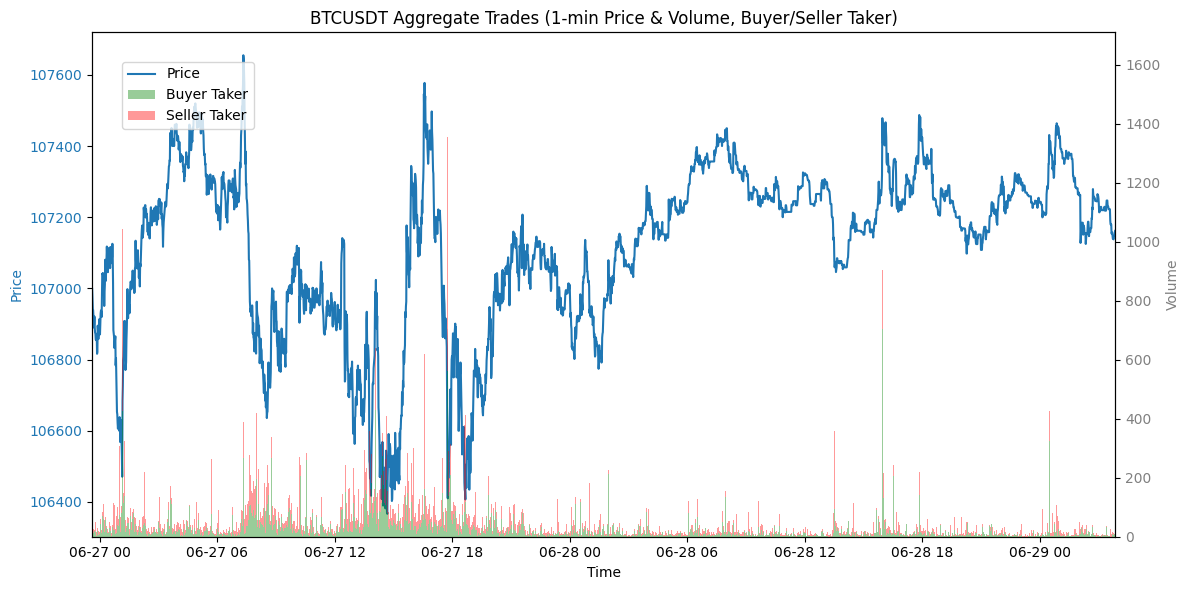

In [ ]:
 # %%

# Prepare DataFrame
# Set aggregation interval in minutes
aggregated_over_minutes = 1  # Change this to 1, 5, 15, 30, etc.

# Prepare DataFrame
df = pd.DataFrame(all_trades)
df['T'] = pd.to_datetime(df['T'], unit='ms')
df['p'] = df['p'].astype(float)
df['q'] = df['q'].astype(float)
df.set_index('T', inplace=True)
df['maker'] = df['m']

# Resample separately for buyer and seller market makers
resample_rule = f'{aggregated_over_minutes}min'
buyers = df[df['maker'] == False].resample(resample_rule).agg({'q': 'sum'}).rename(columns={'q': 'buy_vol'})
sellers = df[df['maker'] == True].resample(resample_rule).agg({'q': 'sum'}).rename(columns={'q': 'sell_vol'})

# Merge with price
agg = df.resample(resample_rule).agg({'p': 'last'}).join(buyers).join(sellers).fillna(0)

from matplotlib.dates import date2num

minute_width = aggregated_over_minutes / 1440  # x minutes in days

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color=color)
ax1.plot(agg.index, agg['p'], color=color, label='Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([agg.index.min(), agg.index.max()])

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='gray')

bar_lefts = date2num(agg.index)
ax2.bar(bar_lefts, agg['buy_vol'], color='green', alpha=0.4, label='Buyer Taker', width=minute_width, align='edge')
ax2.bar(bar_lefts, agg['sell_vol'], color='red', alpha=0.4, label='Seller Taker', width=minute_width, bottom=agg['buy_vol'], align='edge')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title(f"{symbol} Aggregate Trades ({aggregated_over_minutes}-min Price & Volume, Buyer/Seller Taker)")
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

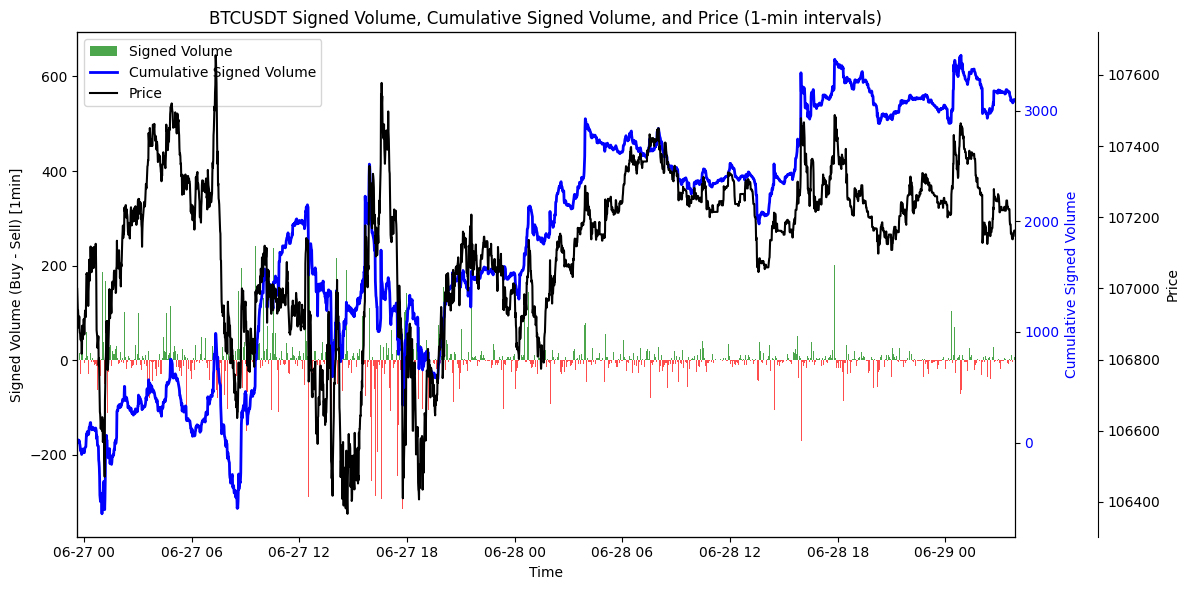

In [ ]:
# %%

# Calculate Signed Volume per minute
agg['net_taker'] = agg['buy_vol'] - agg['sell_vol']
agg['cum_net_taker'] = agg['net_taker'].cumsum()

# Plot Signed Volume per interval (candle-like bars), cumulative sum (line), and price (line)
fig, ax = plt.subplots(figsize=(12, 6))
bar_lefts = date2num(agg.index)
minute_width = aggregated_over_minutes / 1440  # Use the same aggregation as above

# Candle-like bars for Signed Volume
colors = agg['net_taker'].apply(lambda x: 'green' if x >= 0 else 'red')
ax.bar(bar_lefts, agg['net_taker'], color=colors, width=minute_width, align='edge', alpha=0.7, label='Signed Volume')

# Price line (left y-axis)
ax2 = ax.twinx()
ax2.plot(agg.index, agg['cum_net_taker'], color='blue', label='Cumulative Signed Volume', linewidth=2)
ax2.set_ylabel('Cumulative Signed Volume', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a third y-axis for price
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(agg.index, agg['p'], color='black', label='Price', linewidth=1.5)
ax3.set_ylabel('Price', color='black')
ax3.tick_params(axis='y', labelcolor='black')

ax.set_xlabel('Time')
ax.set_ylabel(f'Signed Volume (Buy - Sell) [{aggregated_over_minutes}min]')
ax.set_xlim([agg.index.min(), agg.index.max()])
plt.title(f"{symbol} Signed Volume, Cumulative Signed Volume, and Price ({aggregated_over_minutes}-min intervals)")

# Legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

fig.tight_layout()
plt.show()

In [ ]:
# %%

import numpy as np
from scipy.stats import norm

def corr_confidence_interval(r, n, alpha=0.05):
    """Calculate confidence interval for Pearson correlation using Fisher transformation."""
    if n <= 3:
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    lo = np.tanh(z - z_crit * se)
    hi = np.tanh(z + z_crit * se)
    return lo, hi

correlation = agg['p'].corr(agg['cum_net_taker'])
n = agg.dropna().shape[0]
ci_95 = corr_confidence_interval(correlation, n, alpha=0.05)
print(f"Correlation between price and Cumulative Signed Volume: {correlation:.4f} (95% CI: {ci_95[0]:.4f}, {ci_95[1]:.4f})")

for lag in range(1, 6):
    shifted = agg['cum_net_taker'].shift(lag)
    valid = agg[['p']].join(shifted.rename('shifted')).dropna()
    r = valid['p'].corr(valid['shifted'])
    n_lag = valid.shape[0]
    ci_95 = corr_confidence_interval(r, n_lag, alpha=0.05)
    ci_99 = corr_confidence_interval(r, n_lag, alpha=0.01)
    ci_90 = corr_confidence_interval(r, n_lag, alpha=0.10)
    print(f"Correlation at lag {lag}: {r:.4f} | 90% CI: ({ci_90[0]:.4f}, {ci_90[1]:.4f}) | 95% CI: ({ci_95[0]:.4f}, {ci_95[1]:.4f}) | 99% CI: ({ci_99[0]:.4f}, {ci_99[1]:.4f})")

Correlation between price and Cumulative Signed Volume: 0.4797 (95% CI: 0.4523, 0.5062)
Correlation at lag 1: 0.4774 | 90% CI: (0.4544, 0.4998) | 95% CI: (0.4499, 0.5040) | 99% CI: (0.4411, 0.5121)
Correlation at lag 2: 0.4752 | 90% CI: (0.4521, 0.4976) | 95% CI: (0.4476, 0.5019) | 99% CI: (0.4388, 0.5101)
Correlation at lag 3: 0.4729 | 90% CI: (0.4497, 0.4954) | 95% CI: (0.4452, 0.4996) | 99% CI: (0.4364, 0.5078)
Correlation at lag 4: 0.4707 | 90% CI: (0.4474, 0.4932) | 95% CI: (0.4429, 0.4975) | 99% CI: (0.4340, 0.5057)
Correlation at lag 5: 0.4682 | 90% CI: (0.4449, 0.4909) | 95% CI: (0.4404, 0.4951) | 99% CI: (0.4315, 0.5034)


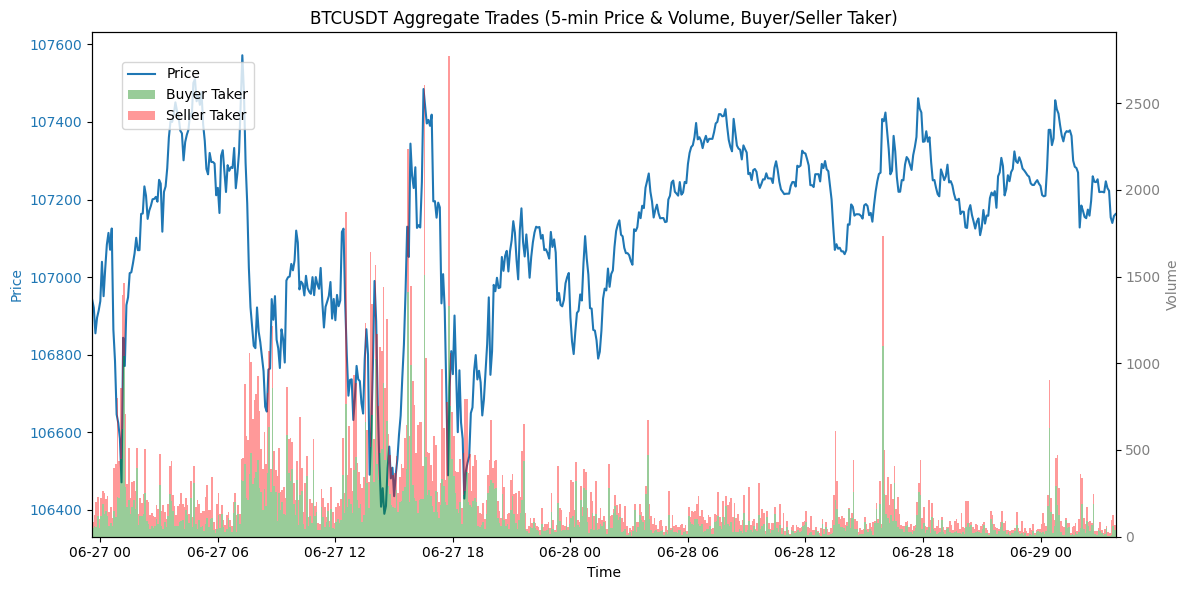

In [ ]:
 # %%

# Prepare DataFrame
# Set aggregation interval in minutes
aggregated_over_minutes = 5  # Change this to 1, 5, 15, 30, etc.

# Prepare DataFrame
df = pd.DataFrame(all_trades)
df['T'] = pd.to_datetime(df['T'], unit='ms')
df['p'] = df['p'].astype(float)
df['q'] = df['q'].astype(float)
df.set_index('T', inplace=True)
df['maker'] = df['m']

# Resample separately for buyer and seller market makers
resample_rule = f'{aggregated_over_minutes}min'
buyers = df[df['maker'] == False].resample(resample_rule).agg({'q': 'sum'}).rename(columns={'q': 'buy_vol'})
sellers = df[df['maker'] == True].resample(resample_rule).agg({'q': 'sum'}).rename(columns={'q': 'sell_vol'})

# Merge with price
agg = df.resample(resample_rule).agg({'p': 'last'}).join(buyers).join(sellers).fillna(0)

from matplotlib.dates import date2num

minute_width = aggregated_over_minutes / 1440  # x minutes in days

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color=color)
ax1.plot(agg.index, agg['p'], color=color, label='Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([agg.index.min(), agg.index.max()])

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='gray')

bar_lefts = date2num(agg.index)
ax2.bar(bar_lefts, agg['buy_vol'], color='green', alpha=0.4, label='Buyer Taker', width=minute_width, align='edge')
ax2.bar(bar_lefts, agg['sell_vol'], color='red', alpha=0.4, label='Seller Taker', width=minute_width, bottom=agg['buy_vol'], align='edge')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title(f"{symbol} Aggregate Trades ({aggregated_over_minutes}-min Price & Volume, Buyer/Seller Taker)")
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

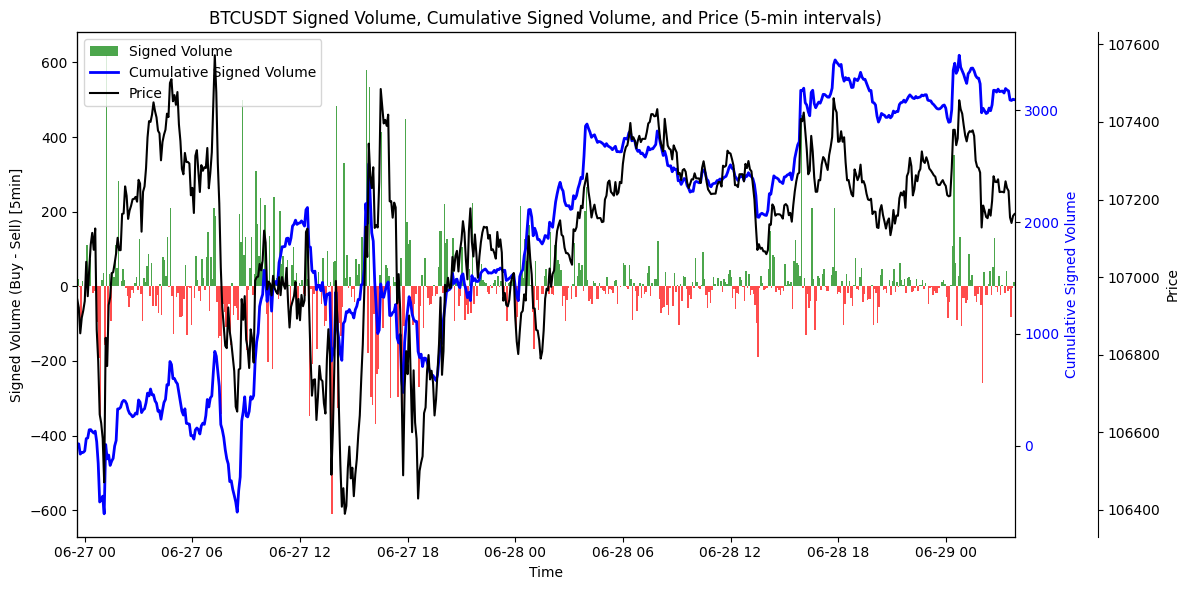

In [ ]:
# %%

# Calculate Signed Volume per minute
agg['net_taker'] = agg['buy_vol'] - agg['sell_vol']
agg['cum_net_taker'] = agg['net_taker'].cumsum()

# Plot Signed Volume per interval (candle-like bars), cumulative sum (line), and price (line)
fig, ax = plt.subplots(figsize=(12, 6))
bar_lefts = date2num(agg.index)
minute_width = aggregated_over_minutes / 1440  # Use the same aggregation as above

# Candle-like bars for Signed Volume
colors = agg['net_taker'].apply(lambda x: 'green' if x >= 0 else 'red')
ax.bar(bar_lefts, agg['net_taker'], color=colors, width=minute_width, align='edge', alpha=0.7, label='Signed Volume')

# Price line (left y-axis)
ax2 = ax.twinx()
ax2.plot(agg.index, agg['cum_net_taker'], color='blue', label='Cumulative Signed Volume', linewidth=2)
ax2.set_ylabel('Cumulative Signed Volume', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a third y-axis for price
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(agg.index, agg['p'], color='black', label='Price', linewidth=1.5)
ax3.set_ylabel('Price', color='black')
ax3.tick_params(axis='y', labelcolor='black')

ax.set_xlabel('Time')
ax.set_ylabel(f'Signed Volume (Buy - Sell) [{aggregated_over_minutes}min]')
ax.set_xlim([agg.index.min(), agg.index.max()])
plt.title(f"{symbol} Signed Volume, Cumulative Signed Volume, and Price ({aggregated_over_minutes}-min intervals)")

# Legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

fig.tight_layout()
plt.show()

In [ ]:
# %%

import numpy as np
from scipy.stats import norm

def corr_confidence_interval(r, n, alpha=0.05):
    """Calculate confidence interval for Pearson correlation using Fisher transformation."""
    if n <= 3:
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    lo = np.tanh(z - z_crit * se)
    hi = np.tanh(z + z_crit * se)
    return lo, hi

correlation = agg['p'].corr(agg['cum_net_taker'])
n = agg.dropna().shape[0]
ci_95 = corr_confidence_interval(correlation, n, alpha=0.05)
print(f"Correlation between price and Cumulative Signed Volume: {correlation:.4f} (95% CI: {ci_95[0]:.4f}, {ci_95[1]:.4f})")

for lag in range(1, 6):
    shifted = agg['cum_net_taker'].shift(lag)
    valid = agg[['p']].join(shifted.rename('shifted')).dropna()
    r = valid['p'].corr(valid['shifted'])
    n_lag = valid.shape[0]
    ci_95 = corr_confidence_interval(r, n_lag, alpha=0.05)
    ci_99 = corr_confidence_interval(r, n_lag, alpha=0.01)
    ci_90 = corr_confidence_interval(r, n_lag, alpha=0.10)
    print(f"Correlation at lag {lag}: {r:.4f} | 90% CI: ({ci_90[0]:.4f}, {ci_90[1]:.4f}) | 95% CI: ({ci_95[0]:.4f}, {ci_95[1]:.4f}) | 99% CI: ({ci_99[0]:.4f}, {ci_99[1]:.4f})")

Correlation between price and Cumulative Signed Volume: 0.4818 (95% CI: 0.4194, 0.5397)
Correlation at lag 1: 0.4713 | 90% CI: (0.4186, 0.5210) | 95% CI: (0.4081, 0.5301) | 99% CI: (0.3874, 0.5476)
Correlation at lag 2: 0.4613 | 90% CI: (0.4079, 0.5116) | 95% CI: (0.3973, 0.5209) | 99% CI: (0.3764, 0.5386)
Correlation at lag 3: 0.4503 | 90% CI: (0.3962, 0.5013) | 95% CI: (0.3855, 0.5107) | 99% CI: (0.3643, 0.5287)
Correlation at lag 4: 0.4406 | 90% CI: (0.3859, 0.4922) | 95% CI: (0.3750, 0.5017) | 99% CI: (0.3536, 0.5200)
Correlation at lag 5: 0.4333 | 90% CI: (0.3782, 0.4854) | 95% CI: (0.3673, 0.4950) | 99% CI: (0.3457, 0.5135)


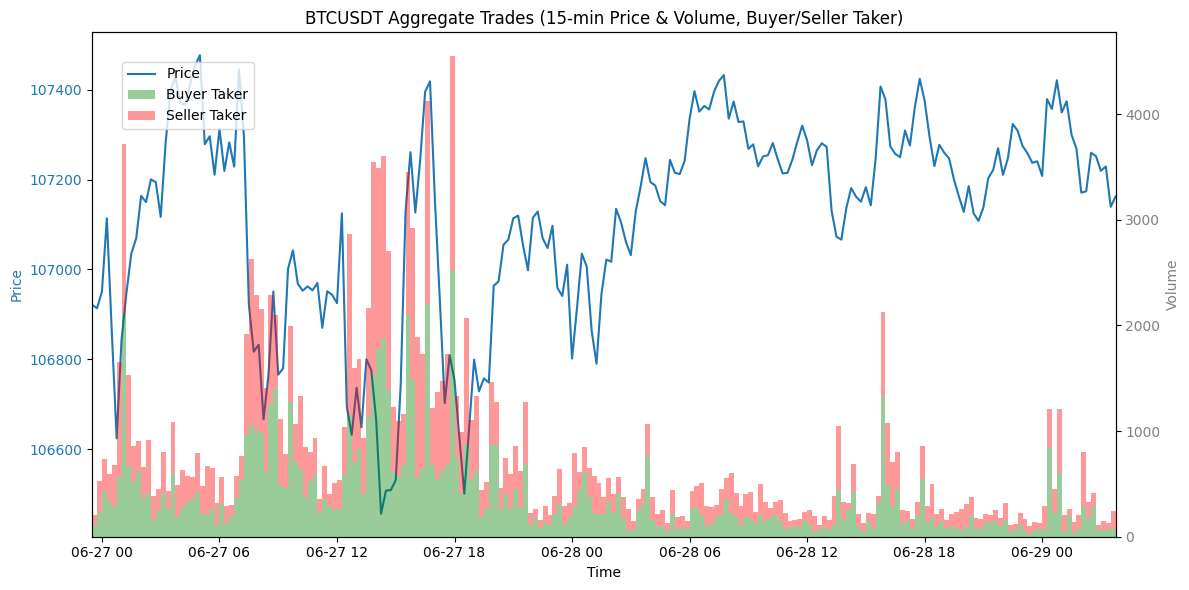

In [ ]:
 # %%

# Prepare DataFrame
# Set aggregation interval in minutes
aggregated_over_minutes = 15  # Change this to 1, 5, 15, 30, etc.

# Prepare DataFrame
df = pd.DataFrame(all_trades)
df['T'] = pd.to_datetime(df['T'], unit='ms')
df['p'] = df['p'].astype(float)
df['q'] = df['q'].astype(float)
df.set_index('T', inplace=True)
df['maker'] = df['m']

# Resample separately for buyer and seller market makers
resample_rule = f'{aggregated_over_minutes}min'
buyers = df[df['maker'] == False].resample(resample_rule).agg({'q': 'sum'}).rename(columns={'q': 'buy_vol'})
sellers = df[df['maker'] == True].resample(resample_rule).agg({'q': 'sum'}).rename(columns={'q': 'sell_vol'})

# Merge with price
agg = df.resample(resample_rule).agg({'p': 'last'}).join(buyers).join(sellers).fillna(0)

from matplotlib.dates import date2num

minute_width = aggregated_over_minutes / 1440  # x minutes in days

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color=color)
ax1.plot(agg.index, agg['p'], color=color, label='Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([agg.index.min(), agg.index.max()])

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='gray')

bar_lefts = date2num(agg.index)
ax2.bar(bar_lefts, agg['buy_vol'], color='green', alpha=0.4, label='Buyer Taker', width=minute_width, align='edge')
ax2.bar(bar_lefts, agg['sell_vol'], color='red', alpha=0.4, label='Seller Taker', width=minute_width, bottom=agg['buy_vol'], align='edge')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title(f"{symbol} Aggregate Trades ({aggregated_over_minutes}-min Price & Volume, Buyer/Seller Taker)")
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

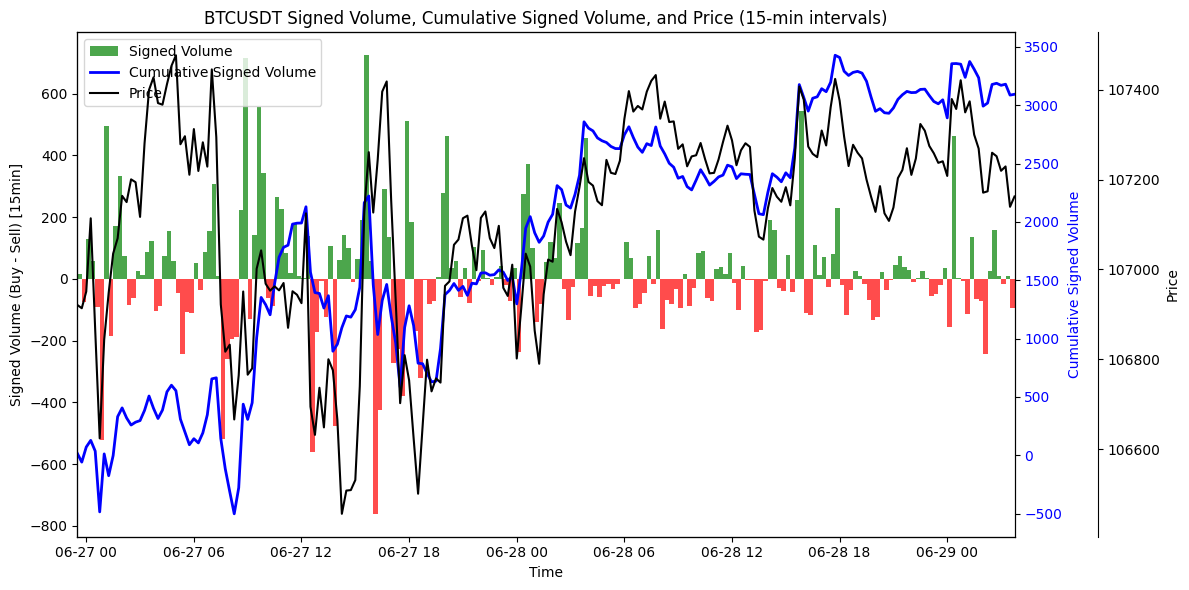

In [ ]:
# %%

# Calculate Signed Volume per minute
agg['net_taker'] = agg['buy_vol'] - agg['sell_vol']
agg['cum_net_taker'] = agg['net_taker'].cumsum()

# Plot Signed Volume per interval (candle-like bars), cumulative sum (line), and price (line)
fig, ax = plt.subplots(figsize=(12, 6))
bar_lefts = date2num(agg.index)
minute_width = aggregated_over_minutes / 1440  # Use the same aggregation as above

# Candle-like bars for Signed Volume
colors = agg['net_taker'].apply(lambda x: 'green' if x >= 0 else 'red')
ax.bar(bar_lefts, agg['net_taker'], color=colors, width=minute_width, align='edge', alpha=0.7, label='Signed Volume')

# Price line (left y-axis)
ax2 = ax.twinx()
ax2.plot(agg.index, agg['cum_net_taker'], color='blue', label='Cumulative Signed Volume', linewidth=2)
ax2.set_ylabel('Cumulative Signed Volume', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a third y-axis for price
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(agg.index, agg['p'], color='black', label='Price', linewidth=1.5)
ax3.set_ylabel('Price', color='black')
ax3.tick_params(axis='y', labelcolor='black')

ax.set_xlabel('Time')
ax.set_ylabel(f'Signed Volume (Buy - Sell) [{aggregated_over_minutes}min]')
ax.set_xlim([agg.index.min(), agg.index.max()])
plt.title(f"{symbol} Signed Volume, Cumulative Signed Volume, and Price ({aggregated_over_minutes}-min intervals)")

# Legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

fig.tight_layout()
plt.show()

In [ ]:
# %%

import numpy as np
from scipy.stats import norm

def corr_confidence_interval(r, n, alpha=0.05):
    """Calculate confidence interval for Pearson correlation using Fisher transformation."""
    if n <= 3:
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    lo = np.tanh(z - z_crit * se)
    hi = np.tanh(z + z_crit * se)
    return lo, hi

correlation = agg['p'].corr(agg['cum_net_taker'])
n = agg.dropna().shape[0]
ci_95 = corr_confidence_interval(correlation, n, alpha=0.05)
print(f"Correlation between price and Cumulative Signed Volume: {correlation:.4f} (95% CI: {ci_95[0]:.4f}, {ci_95[1]:.4f})")

for lag in range(1, 6):
    shifted = agg['cum_net_taker'].shift(lag)
    valid = agg[['p']].join(shifted.rename('shifted')).dropna()
    r = valid['p'].corr(valid['shifted'])
    n_lag = valid.shape[0]
    ci_95 = corr_confidence_interval(r, n_lag, alpha=0.05)
    ci_99 = corr_confidence_interval(r, n_lag, alpha=0.01)
    ci_90 = corr_confidence_interval(r, n_lag, alpha=0.10)
    print(f"Correlation at lag {lag}: {r:.4f} | 90% CI: ({ci_90[0]:.4f}, {ci_90[1]:.4f}) | 95% CI: ({ci_95[0]:.4f}, {ci_95[1]:.4f}) | 99% CI: ({ci_99[0]:.4f}, {ci_99[1]:.4f})")

Correlation between price and Cumulative Signed Volume: 0.4972 (95% CI: 0.3879, 0.5927)
Correlation at lag 1: 0.4715 | 90% CI: (0.3778, 0.5557) | 95% CI: (0.3588, 0.5707) | 99% CI: (0.3208, 0.5990)
Correlation at lag 2: 0.4462 | 90% CI: (0.3496, 0.5333) | 95% CI: (0.3302, 0.5489) | 99% CI: (0.2913, 0.5782)
Correlation at lag 3: 0.4377 | 90% CI: (0.3401, 0.5259) | 95% CI: (0.3204, 0.5417) | 99% CI: (0.2812, 0.5715)
Correlation at lag 4: 0.4373 | 90% CI: (0.3394, 0.5258) | 95% CI: (0.3197, 0.5416) | 99% CI: (0.2804, 0.5714)
Correlation at lag 5: 0.4155 | 90% CI: (0.3153, 0.5064) | 95% CI: (0.2952, 0.5227) | 99% CI: (0.2552, 0.5535)


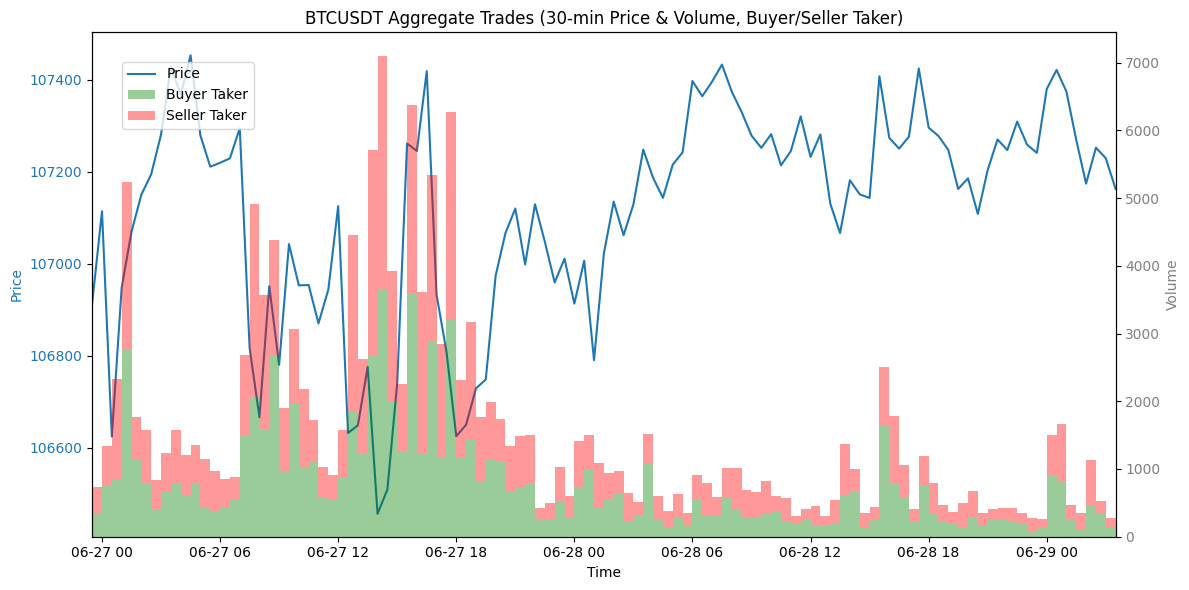

In [ ]:
 # %%

# Prepare DataFrame
# Set aggregation interval in minutes
aggregated_over_minutes = 30  # Change this to 1, 5, 15, 30, etc.

# Prepare DataFrame
df = pd.DataFrame(all_trades)
df['T'] = pd.to_datetime(df['T'], unit='ms')
df['p'] = df['p'].astype(float)
df['q'] = df['q'].astype(float)
df.set_index('T', inplace=True)
df['maker'] = df['m']

# Resample separately for buyer and seller market makers
resample_rule = f'{aggregated_over_minutes}min'
buyers = df[df['maker'] == False].resample(resample_rule).agg({'q': 'sum'}).rename(columns={'q': 'buy_vol'})
sellers = df[df['maker'] == True].resample(resample_rule).agg({'q': 'sum'}).rename(columns={'q': 'sell_vol'})

# Merge with price
agg = df.resample(resample_rule).agg({'p': 'last'}).join(buyers).join(sellers).fillna(0)

from matplotlib.dates import date2num

minute_width = aggregated_over_minutes / 1440  # x minutes in days

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Price', color=color)
ax1.plot(agg.index, agg['p'], color=color, label='Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([agg.index.min(), agg.index.max()])

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='gray')

bar_lefts = date2num(agg.index)
ax2.bar(bar_lefts, agg['buy_vol'], color='green', alpha=0.4, label='Buyer Taker', width=minute_width, align='edge')
ax2.bar(bar_lefts, agg['sell_vol'], color='red', alpha=0.4, label='Seller Taker', width=minute_width, bottom=agg['buy_vol'], align='edge')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title(f"{symbol} Aggregate Trades ({aggregated_over_minutes}-min Price & Volume, Buyer/Seller Taker)")
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

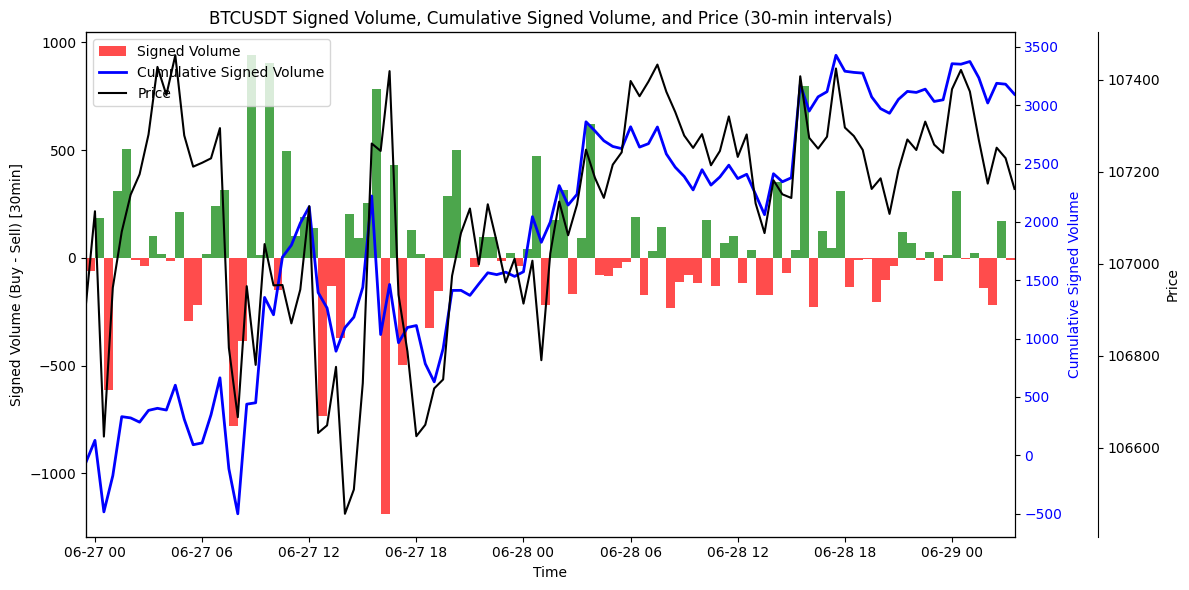

In [ ]:
# %%

# Calculate Signed Volume per minute
agg['net_taker'] = agg['buy_vol'] - agg['sell_vol']
agg['cum_net_taker'] = agg['net_taker'].cumsum()

# Plot Signed Volume per interval (candle-like bars), cumulative sum (line), and price (line)
fig, ax = plt.subplots(figsize=(12, 6))
bar_lefts = date2num(agg.index)
minute_width = aggregated_over_minutes / 1440  # Use the same aggregation as above

# Candle-like bars for Signed Volume
colors = agg['net_taker'].apply(lambda x: 'green' if x >= 0 else 'red')
ax.bar(bar_lefts, agg['net_taker'], color=colors, width=minute_width, align='edge', alpha=0.7, label='Signed Volume')

# Price line (left y-axis)
ax2 = ax.twinx()
ax2.plot(agg.index, agg['cum_net_taker'], color='blue', label='Cumulative Signed Volume', linewidth=2)
ax2.set_ylabel('Cumulative Signed Volume', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a third y-axis for price
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(agg.index, agg['p'], color='black', label='Price', linewidth=1.5)
ax3.set_ylabel('Price', color='black')
ax3.tick_params(axis='y', labelcolor='black')

ax.set_xlabel('Time')
ax.set_ylabel(f'Signed Volume (Buy - Sell) [{aggregated_over_minutes}min]')
ax.set_xlim([agg.index.min(), agg.index.max()])
plt.title(f"{symbol} Signed Volume, Cumulative Signed Volume, and Price ({aggregated_over_minutes}-min intervals)")

# Legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

fig.tight_layout()
plt.show()

In [ ]:
# %%

import numpy as np
from scipy.stats import norm

def corr_confidence_interval(r, n, alpha=0.05):
    """Calculate confidence interval for Pearson correlation using Fisher transformation."""
    if n <= 3:
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    lo = np.tanh(z - z_crit * se)
    hi = np.tanh(z + z_crit * se)
    return lo, hi

correlation = agg['p'].corr(agg['cum_net_taker'])
n = agg.dropna().shape[0]
ci_95 = corr_confidence_interval(correlation, n, alpha=0.05)
print(f"Correlation between price and Cumulative Signed Volume: {correlation:.4f} (95% CI: {ci_95[0]:.4f}, {ci_95[1]:.4f})")

for lag in range(1, 6):
    shifted = agg['cum_net_taker'].shift(lag)
    valid = agg[['p']].join(shifted.rename('shifted')).dropna()
    r = valid['p'].corr(valid['shifted'])
    n_lag = valid.shape[0]
    ci_95 = corr_confidence_interval(r, n_lag, alpha=0.05)
    ci_99 = corr_confidence_interval(r, n_lag, alpha=0.01)
    ci_90 = corr_confidence_interval(r, n_lag, alpha=0.10)
    print(f"Correlation at lag {lag}: {r:.4f} | 90% CI: ({ci_90[0]:.4f}, {ci_90[1]:.4f}) | 95% CI: ({ci_95[0]:.4f}, {ci_95[1]:.4f}) | 99% CI: ({ci_99[0]:.4f}, {ci_99[1]:.4f})")

Correlation between price and Cumulative Signed Volume: 0.5196 (95% CI: 0.3642, 0.6468)
Correlation at lag 1: 0.4601 | 90% CI: (0.3219, 0.5791) | 95% CI: (0.2935, 0.5995) | 99% CI: (0.2365, 0.6373)
Correlation at lag 2: 0.4547 | 90% CI: (0.3151, 0.5751) | 95% CI: (0.2864, 0.5958) | 99% CI: (0.2289, 0.6341)
Correlation at lag 3: 0.3976 | 90% CI: (0.2501, 0.5271) | 95% CI: (0.2202, 0.5496) | 99% CI: (0.1605, 0.5913)
Correlation at lag 4: 0.3512 | 90% CI: (0.1980, 0.4876) | 95% CI: (0.1672, 0.5115) | 99% CI: (0.1062, 0.5560)
Correlation at lag 5: 0.3392 | 90% CI: (0.1840, 0.4778) | 95% CI: (0.1530, 0.5021) | 99% CI: (0.0914, 0.5474)
